In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [25]:
data = pd.read_csv("../data/recipe/merged_data.csv")

In [26]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,38094,40893,4,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,5,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
2,8937,44394,4,devilicious cookie cake delights,20,"['30-minutes-or-less', 'time-to-make', 'course...","[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,"['blend together cake mix , oil and eggs', 'ad...",NaN,"[""devil's food cake mix"", 'vegetable oil', 'eg...",4


In [27]:
data = data[data['rating'] != 0]

In [28]:
data.dropna(inplace=True)

In [29]:
data.drop(['steps'], axis=1, inplace=True)

In [30]:
# Get unique recipe IDs
recipe_ids = data['recipe_id'].unique()

# Define the percentage of recipes to remove
percentage_to_remove = 0.7

# Calculate the number of recipes to remove
num_recipes_to_remove = int(len(recipe_ids) * percentage_to_remove)

# Randomly select recipes to remove
recipes_to_remove = np.random.choice(recipe_ids, num_recipes_to_remove, replace=False)

# Remove rows with selected recipe IDs
data = data[~data['recipe_id'].isin(recipes_to_remove)]

In [31]:
data.head(2)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,description,ingredients,n_ingredients
15,136726,197160,5,mexican hots,20,"['30-minutes-or-less', 'time-to-make', 'course...","[308.0, 23.0, 11.0, 20.0, 54.0, 27.0, 4.0]",2,a family recipe passed down from my grandmothe...,"['hamburger', 'breadcrumbs', 'egg', 'salt', 'b...",10
26,135017,254596,5,apple apricot pork chops crock pot,435,"['course', 'main-ingredient', 'preparation', '...","[710.0, 44.0, 210.0, 7.0, 94.0, 50.0, 21.0]",5,"i'm not sure where i got this recipe, but it's...","['pork chops', 'apple', 'dried apricot', 'cran...",12


In [32]:
data.reset_index(inplace=True, drop=True)

### Encoding and embeddings

In [35]:
from sentence_transformers import SentenceTransformer

s_model = SentenceTransformer("all-MiniLM-L6-v2")
sentence_embeddings = s_model.encode(data['description'])

In [44]:
data['description'] = list(sentence_embeddings)

In [51]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,description,ingredients,n_ingredients
0,136726,197160,5,mexican hots,20,"['30-minutes-or-less', 'time-to-make', 'course...","[308.0, 23.0, 11.0, 20.0, 54.0, 27.0, 4.0]",2,"[-0.12790687, -0.04986197, 0.008629956, 0.0342...","['hamburger', 'breadcrumbs', 'egg', 'salt', 'b...",10
1,135017,254596,5,apple apricot pork chops crock pot,435,"['course', 'main-ingredient', 'preparation', '...","[710.0, 44.0, 210.0, 7.0, 94.0, 50.0, 21.0]",5,"[-0.03198626, -0.016710883, -0.011478343, 0.05...","['pork chops', 'apple', 'dried apricot', 'cran...",12
2,224088,254596,4,apple apricot pork chops crock pot,435,"['course', 'main-ingredient', 'preparation', '...","[710.0, 44.0, 210.0, 7.0, 94.0, 50.0, 21.0]",5,"[-0.031986266, -0.016710903, -0.011478343, 0.0...","['pork chops', 'apple', 'dried apricot', 'cran...",12


In [52]:
sparse_features = ['user_id', 'recipe_id', 'n_steps', 'n_ingredients']
dense_features = ['minutes']
varlen_features = ['tags', 'nutrition', 'description', 'ingredients']

target = 'rating'

In [60]:
import ast

def convert_to_list(string):
    return ast.literal_eval(string)

for feature in varlen_features:
    if not feature == 'description':
        data[feature] = data[feature].apply(convert_to_list)

In [84]:
# Label Encoding tags and ingredients columns
for feature in ['tags', 'ingredients']:
    unique_tags = set(tag for sublist in data[feature] for tag in sublist)

    label_encoder = LabelEncoder()
    label_encoder.fit(list(unique_tags))
    encoded_tags = [label_encoder.transform(tags) for tags in data[feature]]
    data[feature] = encoded_tags

In [85]:
# Scaling nutrition column
nutrition_array = np.array(data['nutrition'].tolist())

scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(nutrition_array)

data['nutrition'] = scaled_array.tolist()

In [96]:
# Scaling minute column
m_scaler = MinMaxScaler()
data_reshaped = data['minutes'].values.reshape(-1, 1)
scaled_data_reshaped = m_scaler.fit_transform(data_reshaped)

scaled_data = scaled_data_reshaped.flatten()

data['minutes'] = list(scaled_data)

In [98]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,description,ingredients,n_ingredients
0,136726,197160,5,mexican hots,0.000069,"[4, 485, 119, 274, 128, 373, 310, 270, 33, 287...","[0.003031057514316334, 0.0013385322702671244, ...",2,"[-0.12790687, -0.04986197, 0.008629956, 0.0342...","[4689, 1036, 3221, 8389, 756, 6739, 4497, 3048...",10
1,135017,254596,5,apple apricot pork chops crock pot,0.001510,"[119, 274, 373, 270, 180, 361, 149, 125, 139, ...","[0.0069871780362486926, 0.0025606704300762378,...",5,"[-0.03198626, -0.016710883, -0.011478343, 0.05...","[7433, 244, 2869, 2460, 6739, 1558, 253, 1123,...",12
2,224088,254596,4,apple apricot pork chops crock pot,0.001510,"[119, 274, 373, 270, 180, 361, 149, 125, 139, ...","[0.0069871780362486926, 0.0025606704300762378,...",5,"[-0.031986266, -0.016710903, -0.011478343, 0.0...","[7433, 244, 2869, 2460, 6739, 1558, 253, 1123,...",12


In [100]:
def pad_varlen(varlen_list, max_len=None):
    if not max_len:
        length = np.array([len(item) for item in varlen_list]) 
        max_len = max(length)
    return (max_len, pad_sequences(varlen_list, maxlen=max_len, padding='post',))

In [101]:
train, test = train_test_split(data, test_size=0.2, stratify=data[target])

In [102]:
(tm, tags_train) = pad_varlen(train['tags'])
(nm, nutrition_train) = pad_varlen(train['nutrition'])
(dm, description_train) = pad_varlen(train['description'])
(im, ingredients_train) = pad_varlen(train['ingredients'])

In [103]:
(_, tags_test) = pad_varlen(test['tags'], tm)
(_, nutrition_test) = pad_varlen(test['nutrition'], nm)
(_, description_test) = pad_varlen(test['description'], dm)
(_, ingredients_test) = pad_varlen(test['ingredients'], im)

In [105]:
max_length = [tm, nm, dm, im]

### Model Training

In [109]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 3, embedding_dim=4, use_hash=True)
                            for feat in sparse_features]

dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat(feat, vocabulary_size=1000, embedding_dim=4),
                        maxlen=max_len, combiner='mean', )
                        for max_len, feat in zip(max_length, varlen_features)]

linear_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [110]:
feature_names

['user_id',
 'recipe_id',
 'n_steps',
 'n_ingredients',
 'minutes',
 'tags',
 'nutrition',
 'description',
 'ingredients']

In [111]:
# Generate input data for model
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

train_model_input['tags'] = tags_train
train_model_input['nutrition'] = nutrition_train
train_model_input['description'] = description_train
train_model_input['ingredients'] = ingredients_train

test_model_input['tags'] = tags_test
test_model_input['nutrition'] = nutrition_test
test_model_input['description'] = description_test
test_model_input['ingredients'] = ingredients_test

In [112]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=20, verbose=2, validation_split=0.2, )

Epoch 1/20
792/792 - 22s - loss: 1.0010 - mse: 1.0002 - val_loss: 0.4779 - val_mse: 0.4759
Epoch 2/20
792/792 - 17s - loss: 0.3683 - mse: 0.3651 - val_loss: 0.5062 - val_mse: 0.5018
Epoch 3/20
792/792 - 16s - loss: 0.2780 - mse: 0.2728 - val_loss: 0.5660 - val_mse: 0.5598
Epoch 4/20
792/792 - 15s - loss: 0.2226 - mse: 0.2159 - val_loss: 0.5786 - val_mse: 0.5713
Epoch 5/20
792/792 - 14s - loss: 0.1888 - mse: 0.1812 - val_loss: 0.6055 - val_mse: 0.5974
Epoch 6/20
792/792 - 21s - loss: 0.1661 - mse: 0.1578 - val_loss: 0.6223 - val_mse: 0.6137
Epoch 7/20
792/792 - 18s - loss: 0.1506 - mse: 0.1419 - val_loss: 0.6167 - val_mse: 0.6076
Epoch 8/20
792/792 - 17s - loss: 0.1380 - mse: 0.1289 - val_loss: 0.6453 - val_mse: 0.6359
Epoch 9/20
792/792 - 17s - loss: 0.1274 - mse: 0.1179 - val_loss: 0.6632 - val_mse: 0.6535
Epoch 10/20
792/792 - 16s - loss: 0.1188 - mse: 0.1091 - val_loss: 0.6618 - val_mse: 0.6519
Epoch 11/20
792/792 - 19s - loss: 0.1118 - mse: 0.1018 - val_loss: 0.6743 - val_mse: 0.66

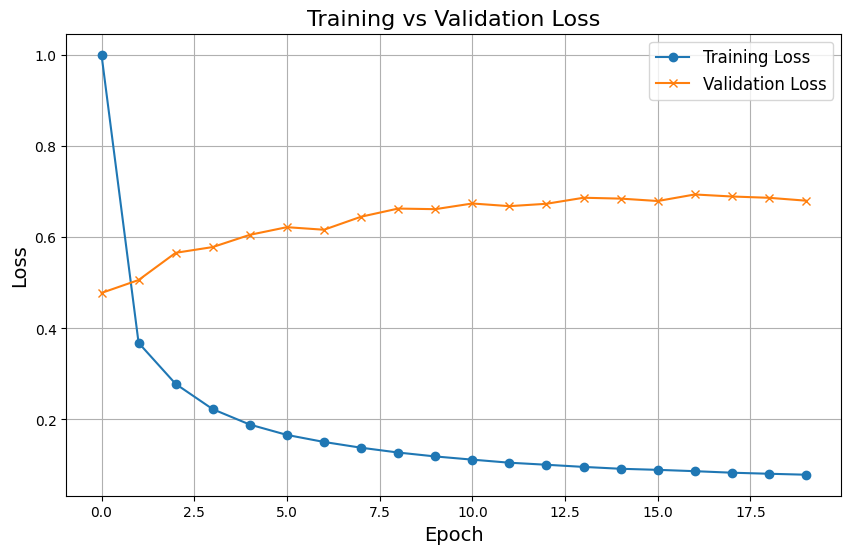

In [113]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [114]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

# Evaluate Model
mse_value = mean_squared_error(test[target].values, pred_ans)
print("Test MSE:", round(mse_value, 4))

Test MSE: 0.6573


### Self Evaluation

In [115]:
ground_truth = test[target].values
prediction = pred_ans
type(ground_truth), type(prediction)

(numpy.ndarray, numpy.ndarray)

In [118]:
indices = np.random.choice(10000, size=10, replace=False)
sample_array1 = ground_truth[indices]
sample_array2 = prediction[indices]

In [119]:
df = pd.DataFrame({'truth': sample_array1.flatten(), 'pred': sample_array2.flatten()})
df['diff'] = np.abs(df['truth'] - df['pred'])
df

,truth,pred,diff
0,4,4.667140,0.667140
1,5,3.895904,1.104096
2,4,4.635739,0.635739
3,5,5.001078,0.001078
4,5,4.883417,0.116583
5,5,4.720557,0.279443
6,5,4.999555,0.000445
7,4,4.772302,0.772302
8,4,4.720670,0.720670
9,5,4.937771,0.062229
